# Data Science Salary Analysis Questions

### Features
- **work_year**: The year of the data related to the job salary.
- **experience_level**: The level of experience of the employee (e.g., entry-level, mid-level, senior-level).
- **employment_type**: The type of employment (e.g., full-time, part-time, contract).
- **job_title**: The title or role of the employee within the data science field.
- **salary**: The salary of the employee.
- **salary_currency**: The currency in which the salary is denoted.
- **salary_in_usd**: The salary converted to US dollars for standardization.
- **employee_residence**: The residence location of the employee.
- **remote_ratio**: The ratio of remote work allowed for the position.
- **company_location**: The location of the company.
- **company_size**: The size of the company based on employee count or revenue.

## Data Setup

In [362]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter, ScalarFormatter

df = pd.read_csv('DataScience_salaries_2024.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L
1,2021,MI,FT,BI Data Analyst,11000000,HUF,36259,HU,50,US,L
2,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
3,2021,MI,FT,ML Engineer,8500000,JPY,77364,JP,50,JP,S
4,2022,SE,FT,Lead Machine Learning Engineer,7500000,INR,95386,IN,50,IN,L


In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           14838 non-null  int64 
 1   experience_level    14838 non-null  object
 2   employment_type     14838 non-null  object
 3   job_title           14838 non-null  object
 4   salary              14838 non-null  int64 
 5   salary_currency     14838 non-null  object
 6   salary_in_usd       14838 non-null  int64 
 7   employee_residence  14838 non-null  object
 8   remote_ratio        14838 non-null  int64 
 9   company_location    14838 non-null  object
 10  company_size        14838 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.2+ MB


In [364]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,14838.000000,1.483800e+04,14838.000000,14838.000000
mean,2023.138900,1.650227e+05,149874.718763,32.760480
std,0.700799,3.562354e+05,69009.181349,46.488278
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.021000e+05,102000.000000,0.000000
50%,2023.000000,1.422000e+05,141300.000000,0.000000
75%,2024.000000,1.875000e+05,185900.000000,100.000000
max,2024.000000,3.040000e+07,800000.000000,100.000000


## Removing outliers

In [365]:
def remove_outliers_std(df, num_std=3, exclude_col=None):
    """
    Remove outliers from a pandas DataFrame using the standard deviation method, 
    with an option to exclude a specific column from being considered for outlier removal.
    
    Parameters:
    - df: pandas DataFrame from which outliers will be removed.
    - num_std: Number of standard deviations from the mean. Values outside
               this range will be considered outliers. Default is 3.
    - exclude_col: Name of the column to exclude from outlier consideration. Default is None.
    
    Returns:
    - A new DataFrame with outliers removed from numeric columns, except for the excluded column.
    """

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if exclude_col and exclude_col in numeric_cols:
        numeric_cols.remove(exclude_col)
    
    mean = df[numeric_cols].mean()
    std = df[numeric_cols].std()
    
    non_outlier_condition = ((df[numeric_cols] >= (mean - num_std * std)) & 
                             (df[numeric_cols] <= (mean + num_std * std)))
    
    # Apply the condition across rows (axis=1) and keep rows where all conditions are True
    return df[non_outlier_condition.all(axis=1)]


df = remove_outliers_std(df, exclude_col='work_year')

## Functions

In [366]:
def calculate_simplification_factor(data, column, simplify):
    """Calculate simplification factor and unit based on the maximum value in the specified column."""
    if not simplify:
        return 1, ''
    
    max_value = data[column].max()
    if abs(max_value) >= 1e6:
        return 1e6, 'M'
    elif abs(max_value) >= 1e3:
        return 1e3, 'K'
    return 1, ''

def configure_y_axis(ax, factor, unit, ylabel):
    """Configure the Y-axis with optional simplification applied to tick labels."""
    formatted_ylabel = f"{ylabel} ({unit})" if unit else ylabel
    ax.set_ylabel(formatted_ylabel)
    if factor > 1:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x/factor:.0f}"))
    else:
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

def simplification(data, column, simplify):
    """Wrapper function to apply simplification based on the provided parameters."""
    factor, unit = calculate_simplification_factor(data, column, simplify)
    return unit, factor

def plot_positions_with_trend(ax, df, column_name, ylabel, title, simplify=False):
    """
    Plot a bar chart with a trend line and annotations on a given axes,
    incorporating optional simplification of displayed numerical values.
    """
    unit, factor = simplification(df, column_name, simplify)

    # Plot the bar chart
    df[column_name].plot(kind='bar', color='skyblue', ax=ax)

    # Add annotations with optional simplification
    for index, value in enumerate(df[column_name]):
        display_value = value / factor
        ax.text(index, value, f"{display_value:.2f}" if simplify else f"{value:.2f}", ha='center', va='bottom')

    # Calculate and plot the trend line using original data values
    x = np.arange(len(df.index))
    y = df[column_name].values
    p = np.poly1d(np.polyfit(x, y, 1))
    ax.plot(x, p(x), "r--")

    # Configure Y-axis and aesthetic improvements
    configure_y_axis(ax, factor, unit, ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=45)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()

def plot_bar_with_trend_and_annotations(ax, data, x_col, y_col, hue_col, hue_legend_title, x_label, y_label, annotate=True, simplify=False):
    """
    Plot a bar plot with annotations for each category defined by hue_col,
    incorporating optional simplification of displayed numerical values.
    """
    unit, factor = simplification(data, y_col, simplify)

    # Plotting the bar plot
    sns.barplot(data=data, x=x_col, y=y_col, hue=hue_col, ax=ax, palette='pastel', width=0.9)

    # Add annotations with optional simplification
    if annotate:
        for p in ax.patches:
            value = p.get_height()
            display_value = value / factor
            ax.annotate(f"{display_value:.0f}" if simplify else f"{value:.0f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points',
                        fontsize=9,
                        rotation=45)

    # Configure Y-axis and aesthetic improvements
    configure_y_axis(ax, factor, unit, y_label)
    ax.set_xlabel(x_label)
    ax.set_title(f'{y_label} by {x_label} and {hue_legend_title}')
    ax.legend(title=hue_legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

def plot_positions_with_trend_linear(ax, df, column_name, ylabel, title, simplify=False):
    """
    Plot a linear chart with a trend line and annotations on a given axes,
    incorporating optional simplification of displayed numerical values.
    """
    # Calculate simplification factor and unit
    unit, factor = simplification(df, column_name, simplify)

    # Plot the line chart
    df[column_name].plot(kind='line', marker='o', color='skyblue', ax=ax)

    # Add annotations with optional simplification
    for index, value in enumerate(df[column_name]):
        display_value = value / factor
        ax.text(index, value, f"{display_value:.2f}" if simplify else f"{value:.2f}", ha='center', va='bottom', fontsize=9)

    # Calculate and plot the trend line using original data values
    x = np.arange(len(df.index))
    y = df[column_name].values
    p = np.poly1d(np.polyfit(x, y, 1))
    ax.plot(x, p(x), "r--", label='Trend line')

    # Configure Y-axis and aesthetic improvements
    configure_y_axis(ax, factor, unit, ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=45)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()

def plot_line_with_trend_and_annotations(ax, data, x_col, y_col, hue_col, hue_legend_title, x_label, y_label, annotate=True, simplify=False):
    """
    Plot a categorized line plot with annotations for each category defined by `hue_col`,
    with an optional simplification of the Y-axis label units. Annotations are based on original values but formatted to reflect simplification.
    """
    sns.set(style="whitegrid")
    palette = sns.color_palette("pastel")

    # Determine the factor for optional simplification and adjust the ylabel accordingly
    factor, unit = calculate_simplification_factor(data, y_col, simplify)
    simplified_ylabel = f"{y_label} ({unit})" if simplify and unit else y_label

    # Plotting the line plot without scaling the actual data for plotting
    sns.lineplot(data=data, x=x_col, y=y_col, hue=hue_col, ax=ax, palette=palette, marker='o', legend='full')

    # Configure Y-axis and aesthetic improvements
    configure_y_axis(ax, factor, unit, y_label)
    ax.set_xlabel(x_label)
    ax.set_title(f'{y_label} by {x_label} and {hue_legend_title}')

    if annotate:
        # Annotate using original value but format to reflect simplification
        for name, group in data.groupby(hue_col):
            for x_value, y_value in zip(group[x_col], group[y_col]):
                display_value = y_value / factor
                annotation_text = f"{display_value:.2f}" if simplify else f"{y_value:.2f}"
                ax.text(x_value, y_value, annotation_text, ha='center', va='bottom', fontsize=9)
    
    ax.legend(title=hue_legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

In [367]:
def increase_heatmap(df, x_col, y_col, hue, x_label, y_label, title):
    """
    Plots a heatmap showing the salary increase per year and experience level.
    
    Parameters:
    - df: DataFrame containing the data.
    - x_col: Name of the column.
    - y_col: Name of the column.
    - hue: Name of the column.
    """
    # Calculate the year-over-year percentage change in salary for each experience level
    df['SalaryIncrease'] = df.sort_values(by=[y_col, x_col]).groupby([y_col])[hue].pct_change() * 100

    # Pivot the data for the heatmap
    heatmap_data = df.pivot_table(index=y_col, columns=x_col, values='SalaryIncrease', aggfunc='mean')

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Salary Increase (%)'})
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Show the plot
    plt.tight_layout()
    plt.show()


## Trend Analysis
1. **How have average data science salaries evolved from 2020 to 2024?**
2. **What is the trend in the number of data science roles reported over the years?**

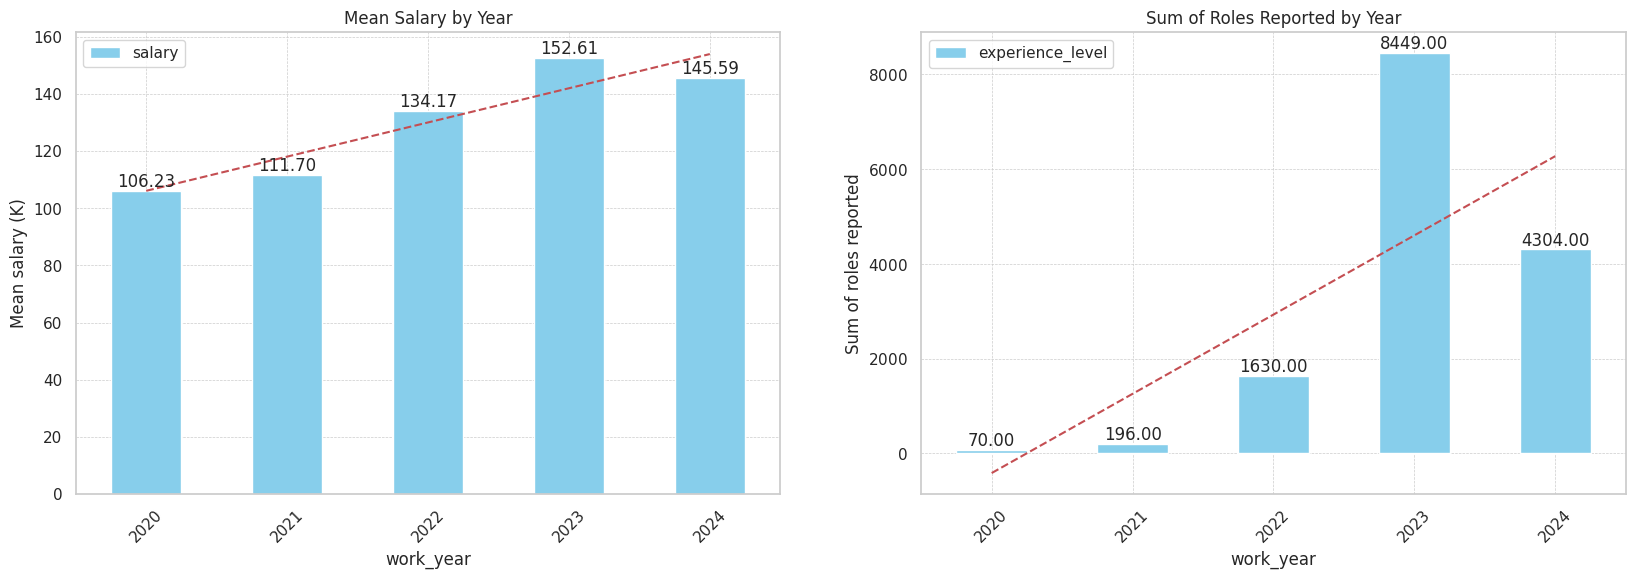

In [368]:
avg_salary_by_year = df[['work_year', 'salary']].groupby(['work_year']).mean()
positions_by_year = df[['work_year', 'experience_level']].groupby(['work_year']).count()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plot_positions_with_trend(axs[0], avg_salary_by_year, 'salary', 'Mean salary', 'Mean Salary by Year', simplify=True)
plot_positions_with_trend(axs[1], positions_by_year, 'experience_level', 'Sum of roles reported', 'Sum of Roles Reported by Year')

plt.show()

## Experience Level Insights
3. **How does the average salary differ between junior and senior data science roles, and what factors contribute to the disparity?**
4. **Which experience level has seen the greatest increase in salaries over the covered years, and what could explain this trend?**



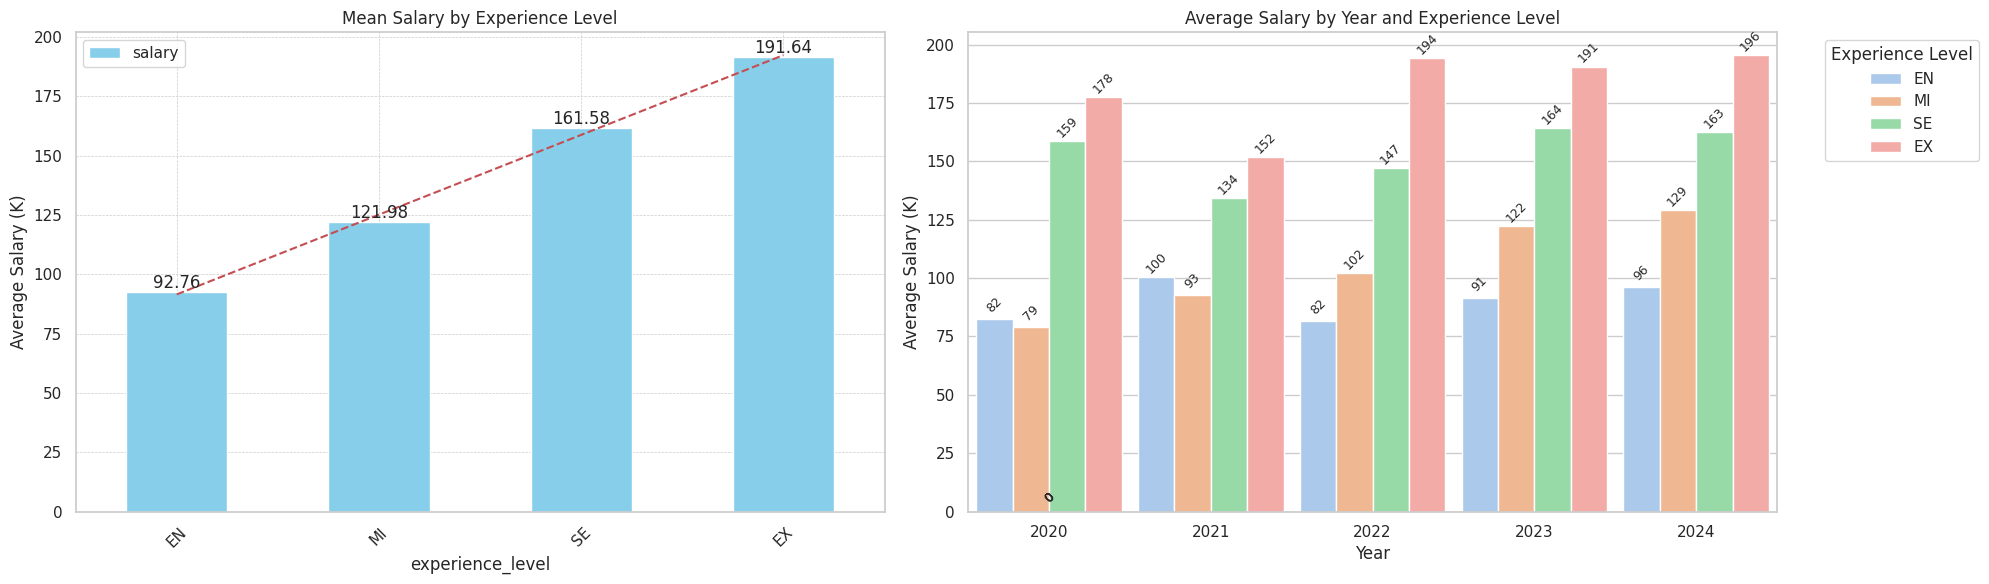

In [369]:
xp_level_x_salary = df[['experience_level', 'salary']].groupby(['experience_level']).mean().reindex(['EN', 'MI', 'SE', 'EX'])

average_salary_by_year_by_xp_level = df.groupby(['work_year', 'experience_level'])['salary'].mean().reset_index()
experience_levels_ordered = ['EN', 'MI', 'SE', 'EX']
average_salary_by_year_by_xp_level['experience_level'] = pd.Categorical(
    average_salary_by_year_by_xp_level['experience_level'],
    categories=experience_levels_ordered,
    ordered=True
)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plot_positions_with_trend(axs[0], xp_level_x_salary, 'salary', 'Average Salary','Mean Salary by Experience Level', simplify=True)

# Utilizando a função generalizada para o segundo gráfico
plot_bar_with_trend_and_annotations(axs[1], average_salary_by_year_by_xp_level, 'work_year', 'salary', 'experience_level', 'Experience Level', 'Year', 'Average Salary', simplify=True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_26500/3098832073.py:128: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(data=data, x=x_col, y=y_col, hue=hue_col, ax=ax, palette=palette, marker='o', legend='full')
/tmp/ipykernel_26500/3098832073.py:137: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in data.groupby(hue_col):


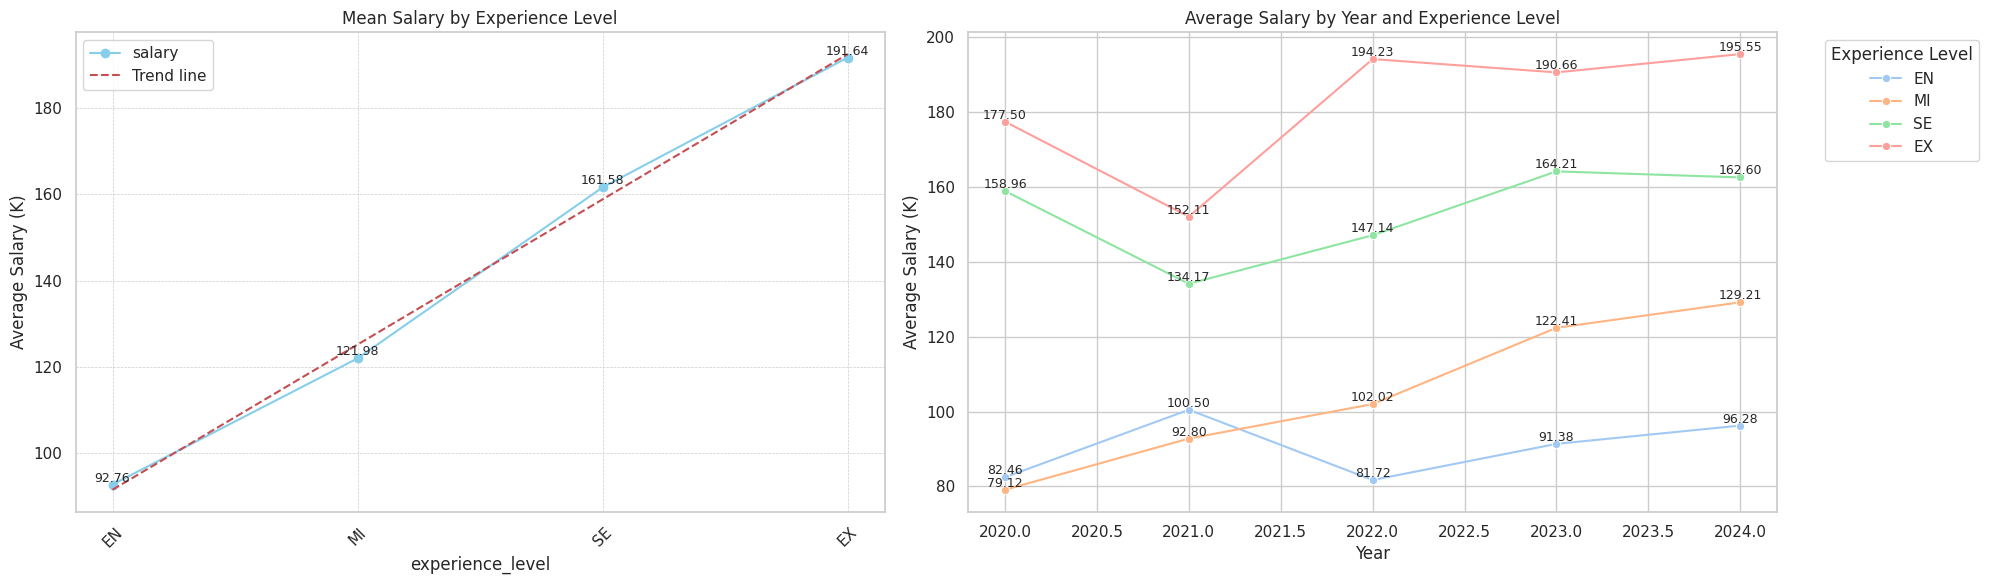

In [370]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plot_positions_with_trend_linear(axs[0], xp_level_x_salary, 'salary', 'Average Salary','Mean Salary by Experience Level', simplify=True)

# Utilizando a função generalizada para o segundo gráfico
plot_line_with_trend_and_annotations(axs[1], average_salary_by_year_by_xp_level, 'work_year', 'salary', 'experience_level', 'Experience Level', 'Year', 'Average Salary', simplify=True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_26500/3649033963.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['SalaryIncrease'] = df.sort_values(by=[y_col, x_col]).groupby([y_col])[hue].pct_change() * 100
/tmp/ipykernel_26500/3649033963.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(index=y_col, columns=x_col, values='SalaryIncrease', aggfunc='mean')


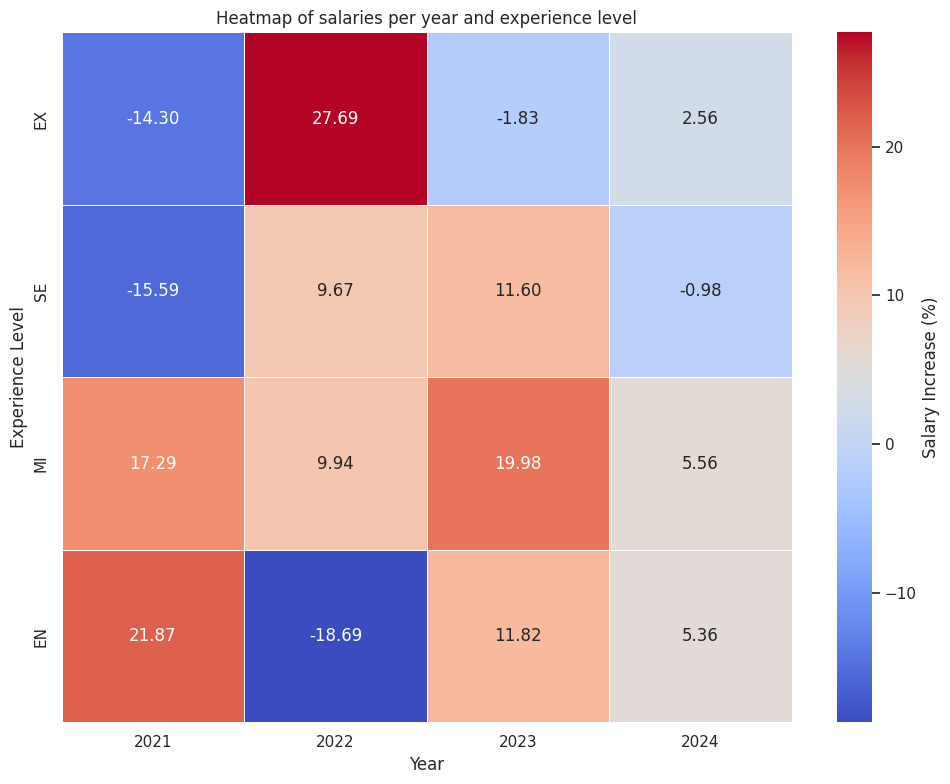

In [371]:
average_salary_by_year_by_xp_level = df.groupby(['work_year', 'experience_level'])['salary'].mean().reset_index()
experience_levels_ordered = ['EX', 'SE', 'MI', 'EN']
average_salary_by_year_by_xp_level['experience_level'] = pd.Categorical(
    average_salary_by_year_by_xp_level['experience_level'],
    categories=experience_levels_ordered,
    ordered=True
)

increase_heatmap(average_salary_by_year_by_xp_level, 'work_year', 'experience_level', 'salary', 'Year', 'Experience Level', 'Heatmap of salaries per year and experience level')

## Employment Type and Work Arrangement
5. **Compare the median salaries across different employment types (Full-Time, Part-Time, Contract, Freelance) and analyze the potential reasons behind the differences.**
6. **Investigate how remote work (no remote, partially remote, fully remote) affects salaries in the data science field, considering other factors like experience level and company size.**



## Geographic Analysis
7. **Identify which country offers the highest average salary for data science professionals, taking into account the cost of living and currency strength.**
8. **Explore the salary differences between company locations and employee residences. Does working for a foreign company correlate with higher salaries?**




## Company Size Impact
9. **Analyze how company size (Small, Medium, Large) impacts the average salary of data science roles, and hypothesize why size matters.**



## Job Title Specific Analysis
10. **What are the most common job titles in the data science field based on this dataset, and how do their salaries compare?**
11. **Which job title receives the highest average salary, and how does this vary by company size and location?**
12. **For data scientists and machine learning engineers, how does experience level influence their salary, and what trends emerge within these specific roles?**



## Cross-Sectional Analysis
13. **Examine the distribution of employment types across different experience levels. Are more experienced professionals more likely to work in certain types of roles?**
14. **What is the relationship between the remote ratio and the size of the company, and how does this affect salary ranges?**



## Yearly Changes and Trends
15. **Identify job titles with the most significant salary changes over the years. What might be causing these fluctuations?**
16. **Analyze the evolution of salaries in the top-paying countries from 2020 to 2024. What geopolitical or economic factors might be influencing these changes?**



## Currency and Global Salary Comparison
17. **Which currencies are most commonly used for salaries, and how do these salary values compare when converted to USD, considering currency fluctuations?**



## High-Paid Role Characteristics
18. **Characterize the highest-paid data science roles in terms of experience level, job title, company size, and location. What common factors contribute to higher salaries?**



## Remote Work Dynamics
19. **What percentage of data science roles are fully remote, and how does this choice correlate with company size and salary?**



## Advanced Comparative Analysis
20. **Perform a comparative analysis between the salary trends of data scientists versus business analysts within the dataset. How do factors like experience level, company size, and geographical location influence the differences in their compensation?**